In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
dataset = pd.read_csv("MH_precrocessed_dataset.csv")

In [3]:
# EDA dan sonra bazı columnları attım çünkü corr matrixi inceledim ve kategorik değerlerin price ile karşılaştırması sonrası gereksiz gördüğümden dolayı:
# Address = Her satıra özel, yüksek kardinaliteli ve tahmin gücü olmayan gürültülü veri
# SellerG = Satıcı adı değişkendir, gelecek tahminlerde tutarsızlığa yol açabilir
# Date = Satış zamanı fiyatla doğrudan ilişkili görünmüyor (gürültü)
# Propertycount = Bölgedeki ilan sayısı, fiyatla doğrudan anlamlı bir korelasyon göstermedi
# Postcode = Fiyat üzerinde çok az etkisi var, ayrıca CouncilArea gibi alternatif sütunlar var
dataset_after_eda = dataset.drop(columns=["Address", "SellerG", "Date", "Propertycount", "Postcode"])

In [4]:
# price distribution tablosu right skewed olduğu için log(1+x) formülüyle log dönüşüm yapıp fiyatlar arasındaki farkı azalttım
price_log = np.log1p(dataset_after_eda["Price"])
mean = price_log.mean()
std = price_log.std()

# yeni bir sütun ekledim. Bu sütun price değerlerini kategoriksel olarak ucuz, orta, pahalı ve lüks diye sınıflandırıyor.
# min ile (mean-std) arası -> Cheap
# (mean-std) ile (mean+std) arası -> Affordable
# (mean+std) ile max arası -> Expensive
# daha sonra data tipini category den object çevirdim
dataset_after_eda["Price_Category"] = pd.cut(price_log, bins = [price_log.min(), mean - std, mean + std, price_log.max()], labels=["Cheap", "Affordable", "Expensive"], include_lowest=True).astype(object)
print(dataset_after_eda[["Price", "Price_Category"]].head())
dataset_after_eda.head()

     Price Price_Category
0   781500     Affordable
1  1056532     Affordable
2  1997500      Expensive
3   600000     Affordable
4  1140000     Affordable


,Suburb,Rooms,Type,Price,Method,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Price_Category
0,Hillside,3,h,781500,S,18.0,3,2,2,666,139,1970,Brimbank City Council,-37.70161,144.753300,Western Metropolitan,Affordable
1,Brighton East,3,h,1056532,S,10.7,3,2,2,196,115,2009,Bayside City Council,-37.93020,145.029000,Southern Metropolitan,Affordable
2,Glen Iris,4,h,1997500,S,7.3,4,2,2,621,216,1945,Boroondara City Council,-37.86544,145.067390,Southern Metropolitan,Expensive
3,Oak Park,3,u,600000,SP,11.5,3,1,2,581,139,1970,Moreland City Council,-37.71667,144.913682,Northern Metropolitan,Affordable
4,Beaumaris,4,h,1140000,S,17.3,4,2,2,790,171,1995,Bayside City Council,-37.97501,145.052570,Southern Metropolitan,Affordable


In [5]:
# price category e göre sınıflandırma yapacağım
y = dataset_after_eda["Price_Category"]
# data leakage olmasın diye price da çıkartıyorum
X = dataset_after_eda.drop(["Price", "Price_Category"], axis=1)

X preprocessing

In [6]:
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
# numerik kategorik değerleri (Rooms, Car, Bedroom2, Bathroom) numerical_cols dan ayırıyorum 
numerical_cols = [col for col in numerical_cols if col not in ["Rooms", "Car", "Bedroom2", "Bathroom"]]
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
# numerik kategorik değerleri (Rooms, Car, Bedroom2, Bathroom) categorical_cols a ekliyorum
categorical_cols.extend(["Rooms", "Car", "Bedroom2", "Bathroom"])

In [7]:
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
bool_cols = X_encoded.select_dtypes(include=["bool"]).columns
X_encoded[bool_cols] = X_encoded[bool_cols].astype(int)
X_encoded.head()

,Distance,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Suburb_Aberfeldie,Suburb_Airport West,Suburb_Albanvale,Suburb_Albert Park,...,Bedroom2_9,Bedroom2_30,Bathroom_1,Bathroom_2,Bathroom_3,Bathroom_4,Bathroom_5,Bathroom_6,Bathroom_7,Bathroom_12
0,18.0,666,139,1970,-37.70161,144.753300,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,10.7,196,115,2009,-37.93020,145.029000,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,7.3,621,216,1945,-37.86544,145.067390,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,11.5,581,139,1970,-37.71667,144.913682,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,17.3,790,171,1995,-37.97501,145.052570,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [8]:
X_encoded_scaled = X_encoded.copy()

# numerical değerlere standard scaler uyguluyorum
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_encoded_scaled[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])
X_encoded_scaled.head()

,Distance,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Suburb_Aberfeldie,Suburb_Airport West,Suburb_Albanvale,Suburb_Albert Park,...,Bedroom2_9,Bedroom2_30,Bathroom_1,Bathroom_2,Bathroom_3,Bathroom_4,Bathroom_5,Bathroom_6,Bathroom_7,Bathroom_12
0,1.004945,0.027141,-0.178461,0.074940,1.251663,-2.087638,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,-0.081595,-0.254946,-0.451312,1.644145,-1.366516,0.224529,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,-0.587654,0.000133,0.696935,-0.930961,-0.624781,0.546488,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0.037478,-0.023875,-0.178461,0.074940,1.079172,-0.742592,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.900756,0.101564,0.185340,1.080841,-1.879752,0.422199,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


y preprocessing

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

Applying RandomUnderSampler for UnderSampling

In [10]:
y.value_counts()

Price_Category
Affordable    1390
Cheap          315
Expensive      295
Name: count, dtype: int64

<Axes: ylabel='count'>

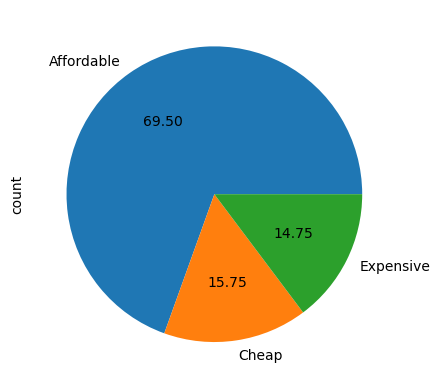

In [11]:
# pie chart ile verinin balanced olup olmadığına bakıyorum
y.value_counts().plot.pie(autopct="%.2f")

In [12]:
# UnderSampling uyguluyorum
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_encoded_scaled_balanced, y_encoded_balanced = rus.fit_resample(X_encoded_scaled, y_encoded)

X_encoded_scaled_balanced = X_encoded_scaled_balanced.reset_index(drop=True)
y_encoded_balanced = pd.Series(y_encoded_balanced).reset_index(drop=True)

In [13]:
y_encoded_balanced.value_counts()

0    295
1    295
2    295
Name: count, dtype: int64

<Axes: ylabel='count'>

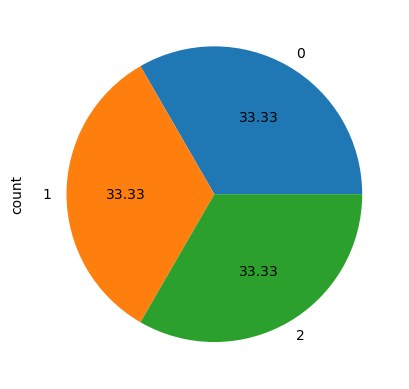

In [14]:
y_encoded_balanced.value_counts().plot.pie(autopct="%.2f")

 Feature Selection with Mutual Information Classification

In [15]:
from sklearn.feature_selection import mutual_info_classif

In [16]:
mi_scores = mutual_info_classif(X_encoded_scaled_balanced, y_encoded_balanced, discrete_features='auto', random_state=42)

# Skorları DataFrame olarak kaydettim
mi_df = pd.DataFrame({
    "Feature": X_encoded_scaled_balanced.columns,
    "MI Score": mi_scores
})

# Skora göre sıraladım
mi_df = mi_df.sort_values(by="MI Score", ascending=False)

In [17]:
# İlk 5 özelliği aldım
top_5_features = mi_df["Feature"].head(5).tolist()
print("Top 5 Features:\n", top_5_features)

Top 5 Features:
 ['BuildingArea', 'Distance', 'Longtitude', 'Lattitude', 'Bathroom_1']


Training Random Forest Model with Top 5 Feature

In [18]:
X_top5 = X_encoded_scaled_balanced[top_5_features]

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [20]:
rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores_all = cross_val_score(rf, X_encoded_scaled_balanced, y_encoded_balanced, cv=cv, scoring="accuracy")
scores_top5 = cross_val_score(rf, X_top5, y_encoded_balanced, cv=cv, scoring="accuracy")

print("All features - CV accuracy: ", round(scores_all.mean(), 2))
print("Top 5 features - CV accuracy: ", round(scores_top5.mean(), 2))

All features - CV accuracy:  0.78
Top 5 features - CV accuracy:  0.73


Feature Selection with Random Forest Classification

In [21]:
rf1 = RandomForestClassifier(random_state=42)
rf1.fit(X_encoded_scaled_balanced, y_encoded_balanced)
importances = rf1.feature_importances_

feat_importances = pd.DataFrame({
    "Feature": X_encoded_scaled_balanced.columns,
    "Importance": importances
})

feat_importances = feat_importances.sort_values(by="Importance", ascending=False)

In [22]:
top5_rf_features = feat_importances["Feature"].head(5).tolist()
print("Top 5 Features:\n", top5_rf_features)

Top 5 Features:
 ['BuildingArea', 'Longtitude', 'Lattitude', 'Distance', 'Landsize']


Training Random Forest Model with Top 5 Feature

In [23]:
X_top5_rf = X_encoded_scaled_balanced[top5_rf_features]

In [24]:
rf2 = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores_rf_top5 = cross_val_score(rf2, X_top5_rf, y_encoded_balanced, cv=cv, scoring="accuracy")

print("All features - CV accuracy: ", round(scores_all.mean(), 2))
print("Top 5 (RF feature importances) - CV accuracy:", round(scores_rf_top5.mean(), 2))

All features - CV accuracy:  0.78
Top 5 (RF feature importances) - CV accuracy: 0.75
